In [1]:
import sys
sys.path.insert(1, "./src")

In [2]:
from pathlib import Path
import yaml
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from transformers import set_seed


from datasets.ner_dataset import get_ner_dataset
from models.bert_model import PretrainedBertNER
from utils.ner_metrics import Statistics
from utils.log_reader import TensorBoardReader
from anonymization.gpt2_generation import GPT2GenerationAnonymization
from models.gpt2_model import PretrainedGPT2TextInfilling
from mask.personal_entity import MaskEntityType

In [3]:
set_seed(42)

In [4]:
# Data config initialisation
i2b2_2006_data_config = yaml.load(open("configs/i2b2-2006_data_config.yaml", 'r'), Loader=yaml.Loader)
i2b2_2014_data_config = yaml.load(open("configs/i2b2-2014_data_config.yaml", 'r'), Loader=yaml.Loader)

In [5]:
# Model config initialisation
bert_base_model_config = yaml.load(open("configs/bert-base_model_config.yaml", 'r'), Loader=yaml.Loader)
bert_large_model_config = yaml.load(open("configs/bert-large_model_config.yaml", 'r'), Loader=yaml.Loader)

In [6]:
# Anonymization config initialisation
anon_config = yaml.load(open("configs/ref_book_anonymization_config.yaml", 'r'), Loader=yaml.Loader)
anon_gpt2_config = yaml.load(open("configs/gpt2_anonymization_config.yaml", 'r'), Loader=yaml.Loader)

### Структура сохранённых моделей:
1. В ```./bert-base/lightning_logs/``` должны храниться модели, основанные на базовом предобученном BERT
    1. Version 0 --- обученаая на нетронутом тренировочном наборе данных i2b2 2006 с учётом регистра
    2. Version 1 --- обученаая на нетронутом тренировочном наборе данных i2b2 2006 без учёта регистра
    3. Version 2 --- обученаая на нетронутом тренировочном наборе данных i2b2 2014 с учётом регистра
    4. Version 3 --- обученаая на нетронутом тренировочном наборе данных i2b2 2014 без учёта регистра
2. В ```./bert-large/lightning_logs/``` должны храниться модели, основанные на большом предобученном BERT
    1. Version 0 --- обученаая на нетронутом тренировочном наборе данных i2b2 2006 с учётом регистра
    2. Version 1 --- обученаая на нетронутом тренировочном наборе данных i2b2 2006 без учёта регистра
    3. Version 2 --- обученаая на нетронутом тренировочном наборе данных i2b2 2014 с учётом регистра
    4. Version 3 --- обученаая на нетронутом тренировочном наборе данных i2b2 2014 без учёта регистра
    5. Version 4 --- обученная на анонимизированном с помощью справочников наборе данных i2b2 2014 без учёта регистра
    6. Version 5 --- обученная на анонимизированном с помощью GPT2 валидационном наборе данных i2b2 2014 без учёта регистра, GPT2 обучено на тренировочном наборе данных i2b2 2014 
    7. Version 6 --- обученная на анонимизированном с помощью GPT2 тренировочном наборе данных i2b2 2006 без учёта регистра, GPT2 обучено на тренировочном наборе данных i2b2 2014 
    8. Version 7 --- обученаая на нетронутом валидационном наборе данных i2b2 2014 без учёта регистра

### Этап 1: Демонстрация качества искусственных примеров личных сущностей
Правдоподобность искусственных примеров будет оцениваться по метрикам их определения лучшей NER моделью --- BERT-large-uncased, дообученной на i2b2 2014

In [7]:
# Инициализация алгоритма генерации искусственных сущностей на основе справочника
model_reader = TensorBoardReader(Path(anon_gpt2_config["log_dir"]) / Path("lightning_logs"))
path_to_checkpoint = model_reader.get_ckpt_path(anon_gpt2_config["model_version"])
text_infill_model = PretrainedGPT2TextInfilling.load_from_checkpoint(path_to_checkpoint).to("cuda:0")

anonymization = GPT2GenerationAnonymization(text_infill_model, 
                                            label2type=lambda x: MaskEntityType[x.upper()], 
                                            mask_types=list(MaskEntityType), **anon_gpt2_config)

In [8]:
# Инициализация обезличенного тестового датасета
test_dataset = get_ner_dataset(path_to_folder=i2b2_2014_data_config["train_data_path"], 
                               anonymization=anonymization, device='cpu',
                               **i2b2_2014_data_config)
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn(),
                             num_workers=10,
                             pin_memory=False,
                             persistent_workers=True)

Start data tokenization


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 574/790 [00:04<00:01, 172.24it/s]

Character span "0808 o’neil’s court" doesn't match with tokens span " 0808 o��neil��s courtfie"
Character span "effingham" doesn't match with tokens span "ffingham  tx"
Character span "tx" doesn't match with tokens span "86"
Character span "726 kehoe avenue" doesn't match with tokens span "26 kehoe avenue  "
Character span "tx" doesn't match with tokens span "23"
Character span "37523" doesn't match with tokens span "7523****"


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [06:40<00:00,  1.43s/it]
Token indices sequence length is longer than the specified maximum sequence length for this model (583 > 512). Running this sequence through the model will result in indexing errors


In [9]:
# Инициализация модели
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
ner_model = PretrainedBertNER.load_from_checkpoint(t_reader.get_ckpt_path(3))

In [10]:
# Тестирование
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:478: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:478: UserWarning: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:478: UserWarning: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1             0.988250195980072
     test_precision          0.988250195980072
       test_recall          0.8206546902656555
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.8206546902656555,
  'test_precision': 0.988250195980072,
  'test_f1': 0.988250195980072}]

              precision    recall  f1-score   support

        NAME     0.8216    0.7812    0.8009     18722
  PROFESSION     0.8475    0.6544    0.7386       654
    LOCATION     0.8390    0.3707    0.5142      9686
         AGE     0.9205    0.7581    0.8314      1893
        DATE     0.8535    0.9786    0.9118     49503
          ID     0.6330    0.5699    0.5998      5606
     CONTACT     0.4726    0.3081    0.3730      2129

   micro avg     0.8286    0.8207    0.8246     88193
   macro avg     0.7697    0.6316    0.6814     88193
weighted avg     0.8233    0.8207    0.8087     88193



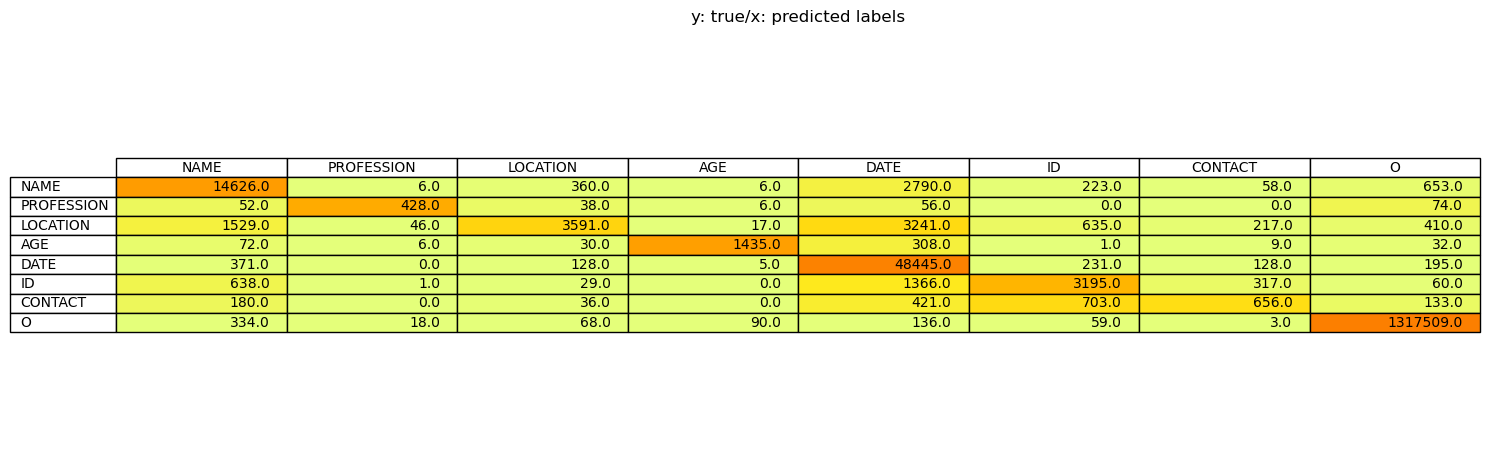

Wrongly predicted examples:
_____ Record 303-03:0 _____
| Sentence:    | yasmine | f | with | dementia | presenting | with | acute | on | chronic | renal | failure | and | delerium | . | etiology | likely | multifactorial | , | however | , | diamox | is | the | only | new | medication | and | may | explain | both | her | worsening | renal | failure | and | delirium | . | will | pursue | broad | differential | as | outlined | above | . |
| True labels: | AGE     | O | O    | O        | O          | O    | O     | O  | O       | O     | O       | O   | O        | O | O        | O      | O              | O | O       | O | O      | O  | O   | O    | O   | O          | O   | O   | O       | O    | O   | O         | O     | O       | O   | O        | O | O    | O      | O     | O            | O  | O        | O     | O |
| Pred labels: | NAME    | O | O    | O        | O          | O    | O     | O  | O       | O     | O       | O   | O        | O | O        | O      | O              | O | O 

In [11]:
# Метрики
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

In [12]:
stats.get_specific_failed_predictions('LOCATION')

Wrongly predicted examples:
_____ Record 127-04:-26 _____
| Sentence:    | record | date | : | 2076 | -    | 12   | -    | 14   | november | 14       | ,        | 2076     | intern | admission | note | pt | : | gabrielle | ,    | nathan | mr | # | 728 | -  | 33 | -  | 14 | admit | date | : | 12   | /    | 14   | pcp | : | ( | - | ) | cc | : | chest | pain | hpi | : | m | hx | dm | , | hlp | , | htn | , | p | / | w | chest | pain | . | pt | reports | having | markedly | reduced | right | eye | visual | acuity | this | evening | , | subsequently | became | increasingly | anxious | and | nervous | and | developed | chest | tightness | across | chest | at | level | of | xiphoid |
| True labels: | O      | O    | O | DATE | DATE | DATE | DATE | DATE | LOCATION | LOCATION | LOCATION | LOCATION | O      | O         | O    | O  | O | NAME      | NAME | NAME   | O  | O | ID  | ID | ID | ID | ID | O     | O    | O | DATE | DATE | DATE | O   | O | O | O | O | O  | O | O     | O    | O   | O | O |

['100-01:-1',
 '100-01:-8',
 '100-01:0',
 '100-03:-1',
 '100-03:-28',
 '100-03:-37',
 '100-03:0',
 '100-05:-1',
 '100-05:0',
 '101-01:-10',
 '101-02:-7',
 '101-03:-10',
 '102-05:-6',
 '104-01:-5',
 '104-02:-13',
 '105-01:-1',
 '105-01:-13',
 '105-01:-25',
 '105-01:0',
 '105-02:-11',
 '105-02:-12',
 '105-05:-26',
 '105-05:-27',
 '106-01:-12',
 '106-03:-5',
 '106-03:-6',
 '106-05:-7',
 '106-05:-8',
 '107-01:-3',
 '107-01:-4',
 '107-01:-8',
 '107-01:-9',
 '107-04:-4',
 '107-04:-5',
 '108-01:-9',
 '108-02:-3',
 '108-03:-34',
 '108-04:-5',
 '108-04:-6',
 '109-01:-10',
 '109-02:-26',
 '120-05:-18',
 '120-05:-19',
 '120-05:-31',
 '120-05:-9',
 '121-01:-1',
 '121-01:-9',
 '121-01:0',
 '121-02:-1',
 '121-02:-7',
 '121-02:0',
 '121-03:-1',
 '121-03:-2',
 '121-03:-9',
 '122-01:-3',
 '122-04:-8',
 '122-05:-17',
 '122-05:-18',
 '123-01:-2',
 '123-01:-3',
 '123-04:-12',
 '124-01:-1',
 '124-01:-10',
 '124-01:-11',
 '124-01:-2',
 '124-01:-21',
 '124-01:-22',
 '124-01:-23',
 '124-01:-27',
 '124-01:-28'

In [13]:
stats.get_specific_failed_predictions('CONTACT')

Wrongly predicted examples:
_____ Record 354-03:-1 _____
| Sentence:    | , | but | not | focal | evidence | of | infection | ppx | : | enoxaparin | may | be | started | after | egd | social | work | consult | to | assess | support | network | and | assist | with | discharge | planning | william | will | assume | care | in | the | morning | . | please | page | dr | . | xavier | directly | at | gmh      | with | questions | arising | after | 8 | : | 00am | . | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | gmc  | , | md | pager |
| True labels: | O | O   | O   | O     | O        | O  | O         | O   | O | O          | O   | O  | O       | O     | O   | O      | O    | O       | O  | O      | O       | O       | O   | O      | O    | O         | O        | NAME    | O    | O      | O    | O  | O   | O       | O | O      | O    | O  | O | NAME   | O        | O  | CONTACT  | O    | O         | O       | O   

['100-04:-1',
 '100-04:0',
 '100-05:-1',
 '100-05:0',
 '102-05:-1',
 '102-05:0',
 '104-03:0',
 '105-05:-3',
 '107-04:-1',
 '107-04:0',
 '109-02:0',
 '121-04:-1',
 '121-04:0',
 '125-03:-23',
 '126-01:0',
 '127-03:-1',
 '127-03:0',
 '127-04:-1',
 '127-04:0',
 '127-05:-1',
 '127-05:-3',
 '127-05:-4',
 '127-05:0',
 '128-04:-1',
 '128-04:0',
 '140-03:-14',
 '140-05:-1',
 '140-05:0',
 '145-02:-1',
 '145-02:0',
 '145-05:0',
 '146-03:-1',
 '146-03:0',
 '146-04:-29',
 '146-04:-30',
 '147-04:0',
 '148-03:0',
 '148-04:0',
 '149-03:-1',
 '149-03:0',
 '151-01:0',
 '151-03:-1',
 '151-03:0',
 '152-03:-1',
 '152-03:0',
 '155-03:-1',
 '155-03:-2',
 '170-03:-1',
 '170-03:-9',
 '170-03:0',
 '170-04:0',
 '170-05:-1',
 '170-05:0',
 '172-02:-9',
 '172-04:-1',
 '172-04:0',
 '173-01:-7',
 '173-01:-8',
 '175-04:-1',
 '175-04:0',
 '176-03:0',
 '177-01:-1',
 '177-01:-2',
 '177-01:0',
 '177-04:-50',
 '177-04:-51',
 '177-05:-22',
 '178-04:-1',
 '178-04:0',
 '179-02:-25',
 '181-03:-10',
 '182-04:0',
 '182-05:-1',
 

**Вывод:**  
В целом все метки предсказываются с точностью, близко к аналогичной у первоначальных сущностей. Самое низкое качество распознавания у модели оказалось для класса 'LOCATION', предположительно, из-за слишком длинных названий больниц в используемом справочнике. Однако в первых версиях генератора синтетических данных присутствовали проблемы с меткой 'CONTACT'. Основная трудность для модели заключалась в предсказании номеров телефонов, если их генерация использовала российский стиль их написания. Тогда модель определяла его, как уникальный идентификатор. Проблема была решена сменной формата номера.  
  
Как видно, в оригинальных данных не используется код страны, и цифры сгруппированы отлично от распространённого российского варианта.  
Запись **347-03**  
Original:  (121) 537-3484  
Russian format: +1 933 257-12-32  
Запись **314-02**  
Original:  (676) 312-7662  
Russian format: +1 995 672-52-24  
  
Ещё один вариант записи номера телефона в оригинальных данных: "665-578-7821"

### Этап 2: Обучение NER на анонимизированных с помощью ILM данных из того же набора

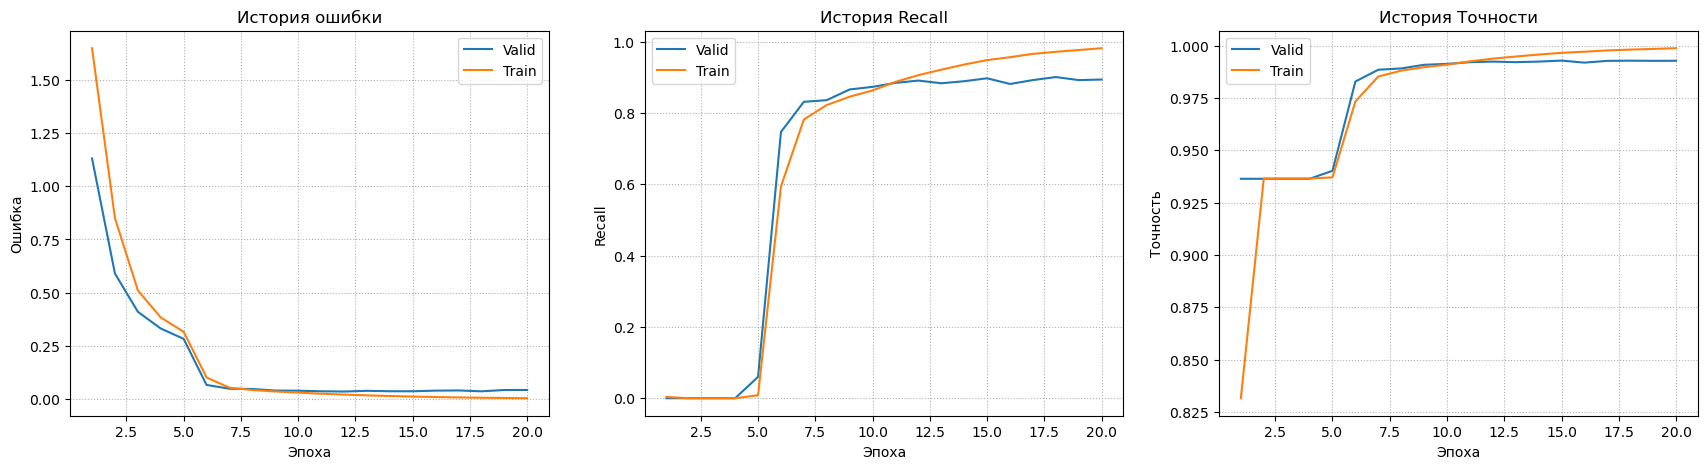

In [14]:
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_ner_tensorboard_graphics(6)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [15]:
# Data processing
test_dataset = get_ner_dataset(path_to_folder=i2b2_2014_data_config["train_data_path"], device='cpu', **i2b2_2014_data_config)
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn(),
                             num_workers=10,
                             pin_memory=False,
                             persistent_workers=True)

Token indices sequence length is longer than the specified maximum sequence length for this model (583 > 512). Running this sequence through the model will result in indexing errors


In [16]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path(6)
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

In [17]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:478: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:478: UserWarning: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:478: UserWarning: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9927758574485779
     test_precision         0.9927758574485779
       test_recall          0.9003635048866272
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.9003635048866272,
  'test_precision': 0.9927758574485779,
  'test_f1': 0.9927758574485779}]

              precision    recall  f1-score   support

        NAME     0.9748    0.8603    0.9140     18570
  PROFESSION     0.7901    0.6530    0.7150       830
    LOCATION     0.7397    0.7905    0.7642      9858
         AGE     0.9309    0.9064    0.9185      2020
        DATE     0.9837    0.9644    0.9739     50531
          ID     0.9055    0.7498    0.8204      6224
     CONTACT     0.7226    0.7326    0.7275      1653

   micro avg     0.9395    0.9004    0.9195     89686
   macro avg     0.8639    0.8082    0.8334     89686
weighted avg     0.9418    0.9004    0.9196     89686



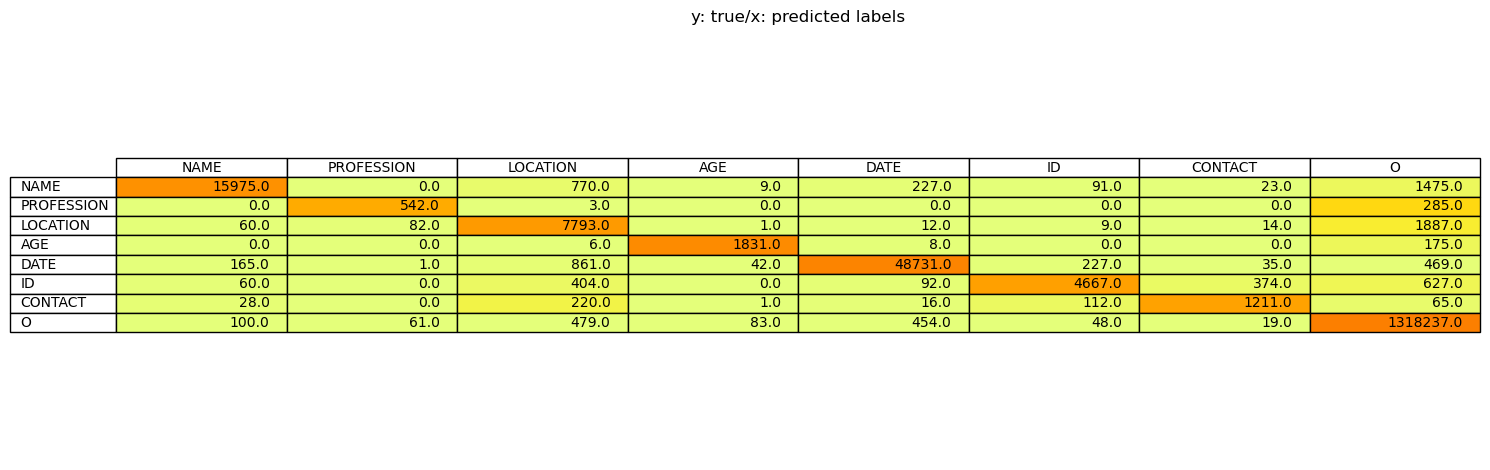

Wrongly predicted examples:
_____ Record 396-03:-11 _____
| Sentence:    | , | edema | , | orthopnea | , | pnd | gi | : | no | nausea | , | vomiting | , | heartburn | , | diarrhea | , | constipation | , | melena | , | hematochezia | breast | : | mammogram | done | 8    | /    | 78   | gu | : | no | dysuria | , | hematuria | . | lmp | : | late | 40s | contraception | : | na | ms | : | no | arthritis | or | joint | pain | neuro | : | no | dizziness | , | syncope | ; | pn | - | numb | but | no | pain | mh | : | no | depression | all |
| True labels: | O | O     | O | O         | O | O   | O  | O | O  | O      | O | O        | O | O         | O | O        | O | O            | O | O      | O | O            | O      | O | O         | O    | DATE | DATE | DATE | O  | O | O  | O       | O | O         | O | O   | O | O    | AGE | O             | O | O  | O  | O | O  | O         | O  | O     | O    | O     | O | O  | O         | O | O       | O | O  | O | O    | O   | O  | O    | O  | O | O  | O

In [18]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

In [19]:
stats.get_specific_failed_predictions('PROFESSION')

Wrongly predicted examples:
_____ Record 287-02:-16 _____
| Sentence:    | social | history | : | divorced | . | 3 | grown | children | . | works | at | calista  | co       | .        | , | veterinarian | for        | exotic     | animals    | . | tobacco | : | 40 | pack | yr | hx | , | quit | before | shoulder | surgery | - | taking | chantix | etoh | : | none | exercise | : | no | formal | exercise | diet | : | no | particular | diet | caffeine | : | 2 | cups | / | day | review | of | systems | : | no | lightheadedness | , | dizziness | , | presyncope | or | syncope | . | no | hx | of | tia | / | cva | / | migraines | / | seizures | physical | examination | : |
| True labels: | O      | O       | O | O        | O | O | O     | O        | O | O     | O  | LOCATION | LOCATION | LOCATION | O | PROFESSION   | PROFESSION | PROFESSION | PROFESSION | O | O       | O | O  | O    | O  | O  | O | O    | O      | O        | O       | O | O      | O       | O    | O | O    | O        | O | O  | 

['106-01:-2',
 '106-02:-11',
 '106-02:-12',
 '106-03:-1',
 '106-03:-2',
 '108-02:-4',
 '120-02:-6',
 '120-02:-7',
 '125-02:-14',
 '125-02:-15',
 '125-03:-10',
 '126-02:-6',
 '126-05:-11',
 '127-03:-37',
 '146-04:-26',
 '147-03:-8',
 '149-03:-14',
 '149-03:-15',
 '151-02:-7',
 '151-02:-8',
 '151-04:-10',
 '151-04:-9',
 '158-04:-10',
 '158-04:-11',
 '170-03:-38',
 '170-03:-39',
 '170-04:-12',
 '170-05:-19',
 '174-01:-10',
 '174-01:-9',
 '174-05:-8',
 '174-05:-9',
 '176-04:-7',
 '176-04:-8',
 '179-04:-10',
 '179-04:-9',
 '187-03:-12',
 '187-04:-12',
 '187-04:-13',
 '220-04:-10',
 '220-04:-9',
 '220-05:-14',
 '220-05:-15',
 '223-02:-5',
 '223-02:-6',
 '223-03:-17',
 '223-04:-6',
 '223-04:-7',
 '224-01:-14',
 '225-02:-11',
 '225-02:-12',
 '226-01:-26',
 '226-01:-27',
 '226-02:-46',
 '226-02:-47',
 '226-04:-22',
 '244-02:-27',
 '252-04:-12',
 '252-04:-13',
 '253-04:-6',
 '256-01:-7',
 '256-01:-8',
 '256-02:-17',
 '256-03:-10',
 '280-02:-6',
 '280-02:-7',
 '285-04:-6',
 '287-01:-11',
 '287-01

In [20]:
stats.get_specific_failed_predictions('CONTACT')

Wrongly predicted examples:
_____ Record 272-04:-5 _____
| Sentence:    | - | will | d | / | c | once | pt | is | stabilized | . | willie | nix  | , | tms      | iii | pager | : | 20243   | 12   | /    | 10   | /    | 94   | intern | addendum | : | patient | seen | and | examined | with | med | student | above | . | agree | with | overall | assessment | above | . | briefly | : | this | is | a | 73  | m | with | a | hx | of | cad | s | / | p | mi | , | s | / | p | aicd | , | iddm | , | htn | , | and | hyperlipidemia | , | who | presents | with | doe | , | pnd | and | bilateral | leg | edema | x4 | days |
| True labels: | O | O    | O | O | O | O    | O  | O  | O          | O | NAME   | NAME | O | LOCATION | O   | O     | O | CONTACT | DATE | DATE | DATE | DATE | DATE | O      | O        | O | O       | O    | O   | O        | O    | O   | O       | O     | O | O     | O    | O       | O          | O     | O | O       | O | O    | O  | O | AGE | O | O    | O | O  | O  | O   | O | O | O |

['105-05:-3',
 '107-04:0',
 '121-04:-28',
 '127-05:-2',
 '127-05:-3',
 '128-04:-1',
 '146-03:-1',
 '146-04:-30',
 '148-04:-1',
 '148-04:0',
 '149-03:-1',
 '149-03:0',
 '151-03:-1',
 '151-03:0',
 '155-03:-1',
 '158-03:-42',
 '158-04:-30',
 '170-03:-1',
 '170-03:-57',
 '170-03:0',
 '172-01:-6',
 '172-02:-9',
 '173-01:-7',
 '175-04:0',
 '177-04:-51',
 '177-04:-52',
 '179-02:-24',
 '181-03:-9',
 '184-03:-15',
 '184-03:-6',
 '187-01:-20',
 '187-03:-34',
 '187-04:-38',
 '221-04:-6',
 '224-03:0',
 '242-03:-2',
 '244-01:-18',
 '254-05:-1',
 '254-05:0',
 '256-02:0',
 '258-04:-1',
 '258-04:-9',
 '258-04:0',
 '270-04:-35',
 '270-04:-36',
 '271-04:-7',
 '272-04:-5',
 '283-03:-24',
 '283-04:-24',
 '288-02:-6',
 '288-02:-7',
 '288-04:-17',
 '290-02:0',
 '290-03:-3',
 '290-03:-4',
 '290-04:-26',
 '292-04:-1',
 '292-04:-2',
 '292-05:-1',
 '292-05:0',
 '295-02:-1',
 '295-02:-13',
 '295-02:-14',
 '295-02:0',
 '296-05:-35',
 '303-03:-1',
 '303-03:-2',
 '304-01:0',
 '306-02:-18',
 '308-03:0',
 '322-04:-68

**Вывод:**  
Заметим, что из-за малого разнообразия формата данных наблюдается переобучение модели после $6$-ой эпохи. Также общее качество работы модели заметно уменьшилось до Recall $=78.71\%$. При этом модель часто принимала класс 'ID' за 'CONTACT', так как искусственно сгенерированные идентификаторы представляют собой непрерываемый поток цифр. Самое же большое падение качества наблюдается в распознавании идентификаторов и имён. Приведём примеры их ошибок, связанных в основном с малым количеством форматов у синтетических данных:

### Этап 3: Обучение NER на анонимизированных с помошью ILM данных из другого набора в том же домене

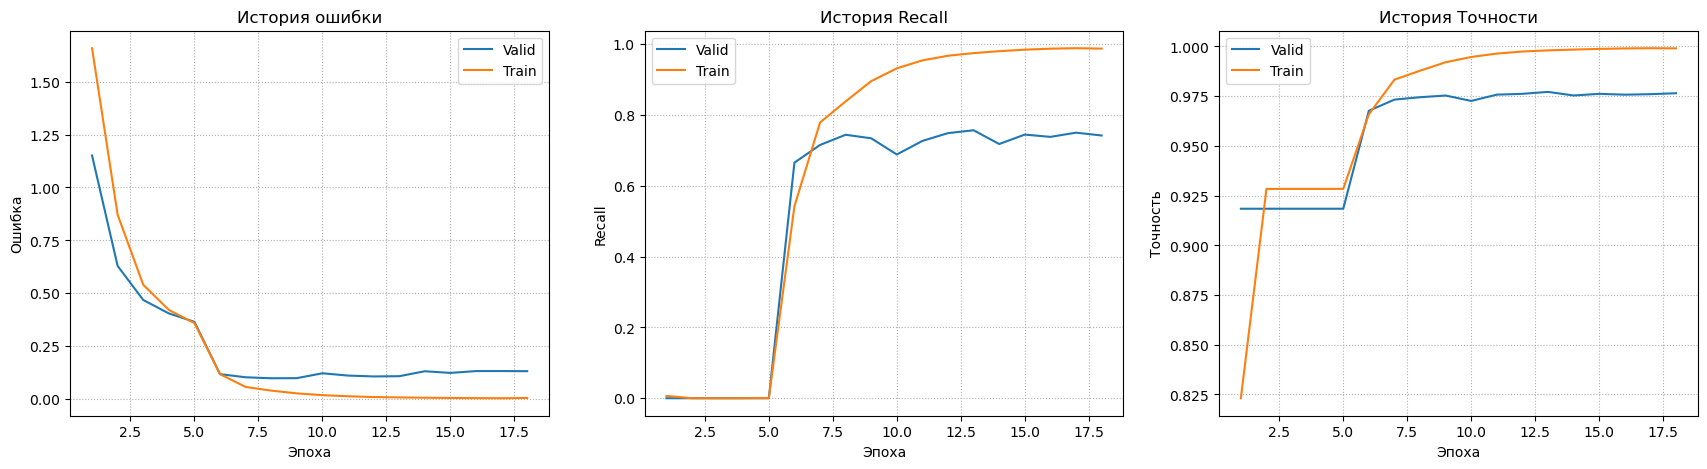

In [21]:
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_ner_tensorboard_graphics(7)

In [22]:
# Data processing
test_dataset = get_ner_dataset(path_to_folder=i2b2_2006_data_config["validate_data_path"], device='cpu', **i2b2_2006_data_config)
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2006_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn(),
                             num_workers=10,
                             pin_memory=False,
                             persistent_workers=True)

Token indices sequence length is longer than the specified maximum sequence length for this model (550 > 512). Running this sequence through the model will result in indexing errors


In [23]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path(7)
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

In [24]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:478: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:478: UserWarning: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:478: UserWarning: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9771324396133423
     test_precision         0.9771324396133423
       test_recall          0.7569381594657898
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.7569381594657898,
  'test_precision': 0.9771324396133423,
  'test_f1': 0.9771324396133423}]

              precision    recall  f1-score   support

        NAME     0.9869    0.7741    0.8676     10501
  PROFESSION     0.0000    0.0000    0.0000         0
    LOCATION     0.8360    0.7700    0.8016      5534
         AGE     0.0000    0.0000    0.0000        10
        DATE     0.8571    0.9549    0.9034      7821
          ID     0.8737    0.4670    0.6086      6264
     CONTACT     0.9463    0.7899    0.8611       714

   micro avg     0.8983    0.7569    0.8216     30844
   macro avg     0.6428    0.5365    0.5775     30844
weighted avg     0.9027    0.7569    0.8118     30844



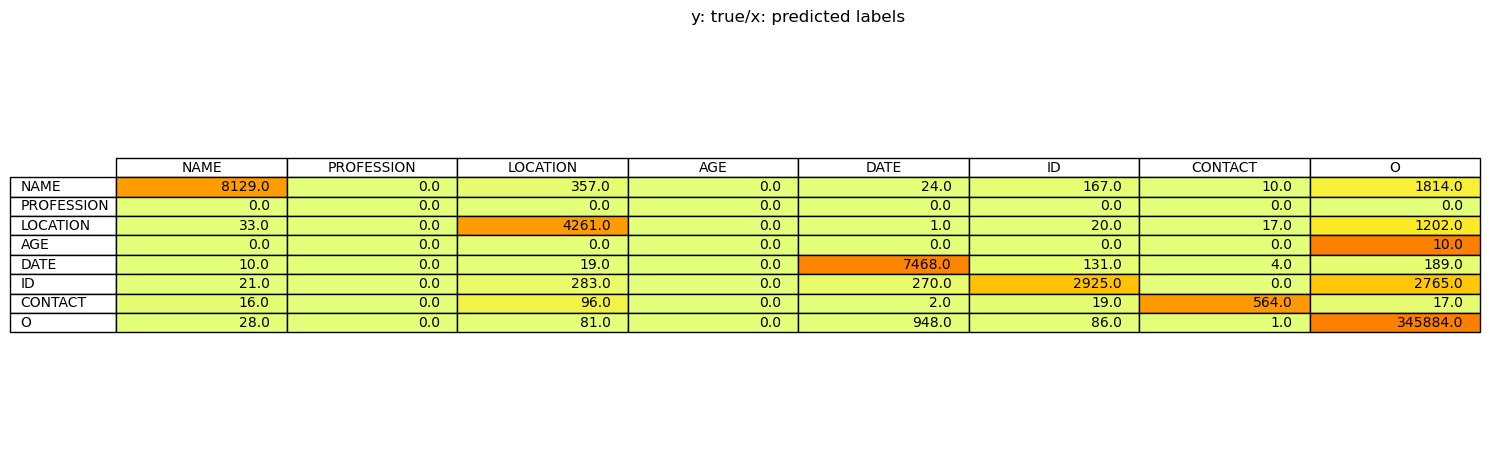

Wrongly predicted examples:
_____ Record 612:-1 _____
| Sentence:    | batch | : | 0420 | index | no | . | k8oty70csz | d | : | 12   | /    | 04   | / | 98 | t | : | 12   | /    | 04   | / | 98 | cc | : | 1 | . | kolo | l    | .    | titchetland | , | m | . | d | . | jh4 | 2 | . | lupevickette | ca   | , | m | . | d | . | 3 | . | trangca | chirdsten | , | m | . | d | . | * | cn | [ | report | _ | end |
| True labels: | O     | O | ID   | O     | O  | O | ID         | O | O | DATE | DATE | DATE | O | O  | O | O | DATE | DATE | DATE | O | O  | O  | O | O | O | NAME | NAME | NAME | NAME        | O | O | O | O | O | ID  | O | O | NAME         | NAME | O | O | O | O | O | O | O | NAME    | NAME      | O | O | O | O | O | O | ID | O | O      | O | O   |
| Pred labels: | O     | O | ID   | O     | O  | O | ID         | O | O | DATE | DATE | DATE | O | O  | O | O | DATE | DATE | DATE | O | O  | O  | O | O | O | NAME | NAME | NAME | NAME        | O | O | O | O | O | O   | O | O | NAME         |

In [25]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

In [26]:
stats.get_specific_failed_predictions('LOCATION')

Wrongly predicted examples:
_____ Record 593:-15 _____
| Sentence:    | diabetes | mellitus | , | controlled | on | glipizide | . | a | history | of | subacute | bacterial | endocarditis | in | 1991 | treated | at | sephsandpot | center   | . | the | organism | was | a | group | b | strep | . | history | of | an | aspiration | pneumonia | in | july | , | 1993 | . | history | of | osteoarthritis | and | history | of | chronic | schizoaffective | disorder | . | medications | on | admission | : | glipizide | 10 | mg | . | qam | . | prilosec | 20 | mg | . | po | . | bid | . |
| True labels: | O        | O        | O | O          | O  | O         | O | O | O       | O  | O        | O         | O            | O  | O    | O       | O  | LOCATION    | LOCATION | O | O   | O        | O   | O | O     | O | O     | O | O       | O  | O  | O          | O         | O  | DATE | O | O    | O | O       | O  | O              | O   | O       | O  | O       | O               | O        | O | O           

['111:-10',
 '111:-11',
 '111:-22',
 '135:-29',
 '151:-15',
 '168:-40',
 '177:-25',
 '177:-27',
 '177:-3',
 '177:-4',
 '185:-1',
 '185:-18',
 '185:-19',
 '185:-2',
 '185:-22',
 '185:0',
 '194:-23',
 '194:-24',
 '194:-31',
 '194:-32',
 '194:-34',
 '202:-25',
 '202:-26',
 '202:-30',
 '202:-6',
 '202:-7',
 '206:-14',
 '214:-1',
 '214:-9',
 '220:-14',
 '233:-24',
 '420:-11',
 '420:-12',
 '420:-17',
 '420:-3',
 '422:-1',
 '422:-28',
 '422:-5',
 '422:0',
 '423:-6',
 '424:-9',
 '426:-3',
 '428:-1',
 '428:-5',
 '428:0',
 '429:-10',
 '430:-18',
 '431:-1',
 '431:-2',
 '432:-4',
 '436:-9',
 '437:-8',
 '438:-14',
 '439:-4',
 '440:-17',
 '440:-3',
 '440:-4',
 '441:-8',
 '442:-2',
 '443:-11',
 '444:-3',
 '445:-3',
 '446:-11',
 '447:-3',
 '448:-15',
 '449:-5',
 '450:-9',
 '451:-4',
 '453:-24',
 '453:-25',
 '454:-1',
 '454:-3',
 '454:-6',
 '455:-2',
 '456:-15',
 '456:-26',
 '457:-5',
 '458:-8',
 '459:-7',
 '460:-9',
 '462:-5',
 '463:-3',
 '465:-1',
 '465:-3',
 '466:-5',
 '467:-5',
 '469:-8',
 '470:-1'

In [27]:
stats.get_specific_failed_predictions('ID')

Wrongly predicted examples:
_____ Record 597:-22 _____
| Sentence:    | 815556500 | fih      | 9164371 | 974151 | 617193 | 12   | /    | 20   | / | 2002 | 12 | : | 00 | : | 00 | am | discharge | summary | signed | dis | report | status | : | signed | discharge | summary | name | : | breunca | ,    | areu | t    | unit | number | : | 961 | -  | 88 | -  | 20 | admission | date | : | 12   | /    | 20   | / | 2002 | discharge | date | : | 12   | /    | 26   | / | 2002 | principal | diagnosis | : | av | nodal | re | - | entrant | tachycardia | ( | avnrt | ) | . | associated | diagnoses | : | 1 |
| True labels: | ID        | LOCATION | ID      | ID     | ID     | DATE | DATE | DATE | O | O    | O  | O | O  | O | O  | O  | O         | O       | O      | O   | O      | O      | O | O      | O         | O       | O    | O | NAME    | NAME | NAME | NAME | O    | O      | O | ID  | ID | ID | ID | ID | O         | O    | O | DATE | DATE | DATE | O | O    | O         | O    | O | DATE | DATE | DATE

['111:-1',
 '111:-2',
 '111:-22',
 '135:-1',
 '135:-2',
 '135:-29',
 '151:-15',
 '168:-40',
 '177:-1',
 '177:-27',
 '177:0',
 '185:-1',
 '185:-2',
 '185:-22',
 '194:-1',
 '194:-33',
 '194:-34',
 '194:0',
 '202:-30',
 '206:-1',
 '206:-14',
 '206:0',
 '214:-8',
 '214:-9',
 '220:-1',
 '220:-13',
 '220:-14',
 '233:-1',
 '233:-23',
 '233:-24',
 '420:-16',
 '420:-17',
 '422:-1',
 '422:-27',
 '422:-28',
 '423:-6',
 '424:-8',
 '424:-9',
 '426:-3',
 '428:-5',
 '429:-10',
 '429:-9',
 '430:-17',
 '430:-18',
 '431:-23',
 '431:-24',
 '431:0',
 '432:-4',
 '436:-8',
 '436:-9',
 '437:-8',
 '438:-1',
 '438:-15',
 '438:-2',
 '439:-4',
 '440:-1',
 '440:-17',
 '441:-8',
 '442:-2',
 '443:-1',
 '443:-11',
 '443:0',
 '444:-2',
 '444:-3',
 '445:-3',
 '446:-11',
 '447:-3',
 '448:-1',
 '448:-2',
 '448:-21',
 '449:-5',
 '450:-9',
 '451:-4',
 '453:-24',
 '453:-25',
 '453:0',
 '454:-1',
 '454:-6',
 '454:0',
 '455:-2',
 '456:-1',
 '456:-26',
 '457:-5',
 '458:-8',
 '459:-1',
 '459:-2',
 '459:-6',
 '459:-7',
 '460:-1

**Вывод:**  
Заметим, что из-за малого разнообразия формата данных наблюдается переобучение модели после $6$-ой эпохи. Также общее качество работы модели заметно уменьшилось до Recall $=78.71\%$. При этом модель часто принимала класс 'ID' за 'CONTACT', так как искусственно сгенерированные идентификаторы представляют собой непрерываемый поток цифр. Самое же большое падение качества наблюдается в распознавании идентификаторов и имён. Приведём примеры их ошибок, связанных в основном с малым количеством форматов у синтетических данных: